In [38]:
import os
import json
from django.core.exceptions import ImproperlyConfigured

PROJECT_DIR = "."
BASE_DIR = os.path.dirname(PROJECT_DIR)

KEYSDIR = str(BASE_DIR) + "secrets.json"

with open(KEYSDIR) as k:
    project_keys = json.loads(k.read())


def getKey(setting, project_keys=project_keys):
    try:
        return project_keys[setting]
    except KeyError:
        errorMessage = "Set the {} env var".format(setting)
        raise ImproperlyConfigured(errorMessage)

In [39]:
import pprint
from pyseoanalyzer import analyze

site = "https://www.charlie-marshall.dev"

results = analyze(site, analyze_headings=True, analyze_extra_tags=True)

warnings = {}

for page in results["pages"]:
    # print(page['headings'])
    warnings_list = page["warnings"]
    warning_types = [w.split(":")[0] for w in warnings_list]
    for wt in warning_types:
        warning_type = warnings.get(wt)
        if not warning_type:
            warnings[wt] = 1
        else:
            warnings[wt] += 1

print(warnings)

{'Anchor missing title tag': 107, 'Missing og': 9, 'Title tag is too short (less than 10 characters)': 1, 'Missing description': 1, 'Description is too short (less than 140 characters)': 1}


In [ ]:
import requests

CATEGORIES = [1, 2, 3, 4, 5]

KEY = getKey("GOOGLE_API_KEY")
ENDPOINT = "https://www.googleapis.com/pagespeedonline/v5/runPagespeed"


def get_params(site):
    # print("Getting params...")
    return (
        f"?url={site}&key={KEY}&category=1&category=2&category=3&category=4&category=5"
    )


def call_api(url):
    # print("Calling API...")
    response = requests.get(url)
    return response.json()


def parse_lighthouse_result(lighthouse_result):
    # print("Parsing lighthouse result...")
    audits = None
    categories = None
    if lighthouse_result:
        audits = lighthouse_result.get("audits")
        categories = lighthouse_result.get("categories")
    else:
        pass
        # print("No lighthouse score...")
    return audits, categories


def parse_categories(categories):
    # print("Parsing categories...")
    accessibility = None
    best_practices = None
    performance = None
    seo = None
    if categories:
        accessibility = categories.get("accessibility")
        best_practices = categories.get("best-practices")
        performance = categories.get("performance")
        seo = categories.get("seo")
        print(seo)
    return accessibility, best_practices, performance, seo


def parse_score(category: dict):
    # print("parsing score...")
    if category:
        return category.get("score")


def parse_audit_refs_dicts(category: dict):
    # print("Parsing audit refs...")
    if category:
        return category.get("auditRefs")


def format_binary_score(binary_score):
    # print("Formatting binary score...")
    if binary_score:
        return True
    else:
        return False


def format_audit_name(audit_name):
    # print(f"Formatting audit name {audit_name}...")
    return audit_name.replace("-", "_")


def get_formatted_score(score, score_display_mode):
    # print(f"Getting formatted score {score} of display type: {score_display_mode}")
    if score_display_mode == "notApplicable":
        return None
    elif score_display_mode == "binary":
        return format_binary_score(score)
    elif score_display_mode in ["numeric", "informative"]:
        return int(score)
    elif score_display_mode == "metricSavings":
        return float(score)


def get_score(audit, score_display_mode):
    # print("Getting score...")
    if score_display_mode:
        return get_formatted_score(audit.get("score"), score_display_mode)
    # print("No score display mode")


def audit_key_show(audit):
    for k in audit.keys():
        if k == "numericValue":
            print(f"TITLE: {audit['title']}, VALUE: {audit['numericValue']}")


def parse_audits_scores(audits, audit_refs_dicts):
    audits_scores = {}
    for audit_ref in audit_refs_dicts:
        # print(f"Getting score for audit: {audit_ref}")
        score = None
        audit = audits.get(audit_ref)
        # print(audit.keys())
        audit_key_show(audit)
        audit_name = format_audit_name(audit_ref)
        if audit:
            score_display_mode = audit.get("scoreDisplayMode")
            score = get_score(audit, score_display_mode)

            audits_scores[audit_name] = score
    return audits_scores


def parse_response(response):
    # print("Parsing response")
    parsed_response = {}

    lighthouse_result = response.get("lighthouseResult")

    audits, categories = parse_lighthouse_result(lighthouse_result)
    accessibility, best_practices, performance, seo = parse_categories(categories)

    accessibility_score = parse_score(accessibility)
    best_practices_score = parse_score(best_practices)
    performance_score = parse_score(performance)
    seo_score = parse_score(seo)

    accessibility_audit_refs_dicts = parse_audit_refs_dicts(accessibility)
    best_practices_audit_refs_dicts = parse_audit_refs_dicts(best_practices)
    performance_audit_refs_dicts = parse_audit_refs_dicts(performance)
    seo_audit_refs_dicts = parse_audit_refs_dicts(seo)

    accessibility_audit_scores = parse_audits_scores(
        audits, accessibility_audit_refs_dicts
    )
    accessibility_audit_scores["score"] = accessibility_score
    best_practices_audit_scores = parse_audits_scores(
        audits, best_practices_audit_refs_dicts
    )
    best_practices_audit_scores["score"] = best_practices_score
    performance_audit_scores = parse_audits_scores(audits, performance_audit_refs_dicts)
    performance_audit_scores["score"] = performance_score
    seo_audit_scores = parse_audits_scores(audits, seo_audit_refs_dicts)
    seo_audit_scores["score"] = seo_score

    parsed_response["accessibility"] = accessibility_audit_scores
    parsed_response["best_practices"] = best_practices_audit_scores
    parsed_response["performance"] = performance_audit_scores
    parsed_response["seo"] = seo_audit_scores
    return parsed_response


def run(site):
    url = ENDPOINT + get_params(site)
    response = call_api(url)
    parsed_response = parse_response(response)
    return parsed_response


site = "https://www.charlie-marshall.dev"
parsed_response = run(site)

{'id': 'seo', 'title': 'SEO', 'description': 'These checks ensure that your page is following basic search engine optimization advice. There are many additional factors Lighthouse does not score here that may affect your search ranking, including performance on [Core Web Vitals](https://web.dev/explore/vitals). [Learn more about Google Search Essentials](https://support.google.com/webmasters/answer/35769).', 'score': 0.83, 'manualDescription': 'Run these additional validators on your site to check additional SEO best practices.', 'auditRefs': [{'id': 'is-crawlable', 'weight': 4.043478260869565, 'group': 'seo-crawl'}, {'id': 'document-title', 'weight': 1, 'group': 'seo-content'}, {'id': 'meta-description', 'weight': 1, 'group': 'seo-content'}, {'id': 'http-status-code', 'weight': 1, 'group': 'seo-crawl'}, {'id': 'link-text', 'weight': 1, 'group': 'seo-content'}, {'id': 'crawlable-anchors', 'weight': 1, 'group': 'seo-crawl'}, {'id': 'robots-txt', 'weight': 0, 'group': 'seo-crawl'}, {'id'

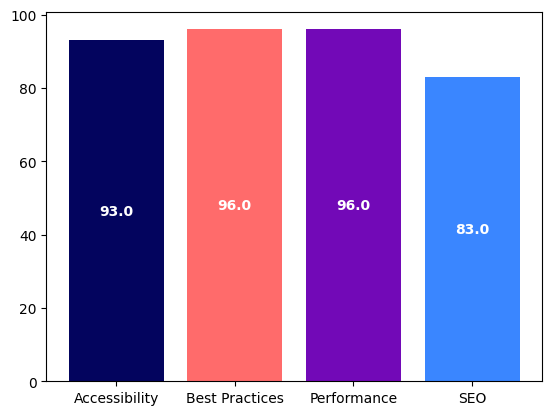

In [ ]:
from matplotlib import pyplot as plt

colors = ["#03045E", "#FF6B6B", "#7209B7", "#3A86FF"]
x = ["Accessibility", "Best Practices", "Performance", "SEO"]
y = [
    parsed_response["accessibility"]["score"] * 100,
    parsed_response["best_practices"]["score"] * 100,
    parsed_response["performance"]["score"] * 100,
    parsed_response["seo"]["score"] * 100,
]

bars = plt.bar(x, y, label="Core Website Scores", color=colors)
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,  # x-position
        height / 2,  # y-position (middle of bar)
        f"{height}",  # text
        ha="center",  # horizontal alignment
        va="center",  # vertical alignment
        color="white",  # text color
        fontweight="bold",
    )

bars.set_label("Core Website Scores")